In [ ]:
from torchvision import models # здесь лежат предобученные сетки

#import argparse
from types import SimpleNamespace # простой класс, где можно прописать параметры
import json

# Для визуализации
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image 
import time
import scipy
from google.colab import files

# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Пример использования предобученной модели


In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True).eval() # загружаем готовую vgg16 с предобученными весами, переключаем в режим проверки (evaluate)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Загружаем разметку между названием класса и соответствующему ему числу

In [ ]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json # подгружаем одной командой (из документации ImageNet)
class_idx = json.load(open("imagenet_class_index.json")) # подгружаем json файл
idx2label = np.array([class_idx[str(k)][1] for k in range(len(class_idx))]) # по всей длине индексов классов вытаскиваем название
!ls

In [ ]:
print (class_idx) # Отобразим class_idx

In [ ]:
print(idx2label[:20]) # посмотрим на список всех лейблов
print(len(idx2label)) # Отобразим количество классов

['tench' 'goldfish' 'great_white_shark' 'tiger_shark' 'hammerhead'
 'electric_ray' 'stingray' 'cock' 'hen' 'ostrich' 'brambling' 'goldfinch'
 'house_finch' 'junco' 'indigo_bunting' 'robin' 'bulbul' 'jay' 'magpie'
 'chickadee']
1000


vgg16 была обучена на датасете imagenet, где входящие значения были нормализованы следующим образом:

In [ ]:
# Задаем набор трансформаций
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16.avgpool # выводим слой, отвечающий за классификацию

AdaptiveAvgPool2d(output_size=(7, 7))

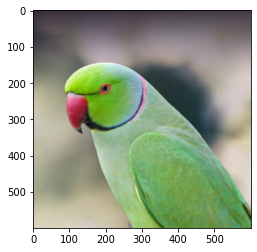

In [ ]:
im_org = Image.open('/content/drive/My Drive/Базы/Parakeet.jpg')
im_org = np.array(im_org)
plt.imshow(im_org)
plt.show()

In [ ]:
pk = Image.open('/content/drive/My Drive/Базы/Parakeet.jpg')
pk = transform(pk)
pk.shape

torch.Size([3, 600, 600])

In [ ]:
k = vgg16.avgpool(pk.unsqueeze(0))
k.shape

torch.Size([1, 3, 7, 7])

In [ ]:
tns = np.random.random(size=(1,3,3,3))
tns_t = torch.from_numpy(tns)
k = vgg16.avgpool(tns_t)
k.shape

torch.Size([1, 3, 7, 7])

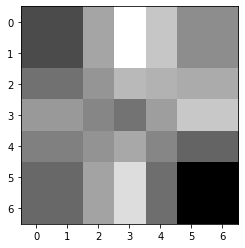

In [ ]:
plt.imshow(k.squeeze()[0].data.numpy(), cmap='gray')
plt.show()

Рассмотрим данную сеть



In [ ]:
# Загружаем картинку
im_org = Image.open('/content/drive/My Drive/Базы/Parakeet.jpg') 

# Применяем нормализацию
im = transform(im_org)
print(im.shape)

torch.Size([3, 600, 600])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Метка класса: lorikeet - Вероятность: 0.184199
Метка класса: bee_eater - Вероятность: 0.046971
Метка класса: macaw - Вероятность: 0.039322
Метка класса: toucan - Вероятность: 0.029853
Метка класса: Granny_Smith - Вероятность: 0.019452


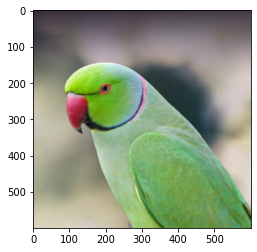

In [ ]:
#Пропустим через софтмакс выход с последнего слоя предобученной сети, через которую мы прогнали наше изображение
probas = nn.Softmax()(vgg16(im.unsqueeze(0))).view(-1) # добавляем дополнительное измерение,
                                                       # чтобы получить тензор формата [размер batch, ширина, высота, количество каналов]
                                                       # и вытягиваем в вектор
                                                       
sortedOuputs = torch.argsort(probas, descending=True) # в соответствие с каждой вероятностью подбираем класс

# Вывод 5 наиболее вероятных классов
for i in range(5):
    print("Метка класса: {:s} - Вероятность: {:4f}".format(
        idx2label[sortedOuputs[i]], probas[sortedOuputs[i]]))
    
plt.imshow(im_org)
plt.show()

In [ ]:
im.unsqueeze(0).shape # unsqueeze добавляет одну размерность под батч (0 - в начало, -1 - в конец)

torch.Size([1, 3, 600, 600])

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

7


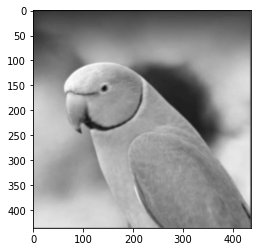

22


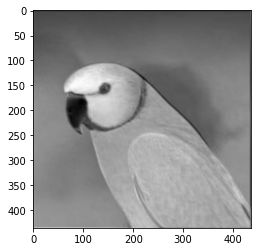

41


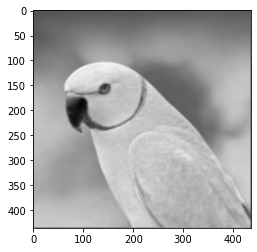

47


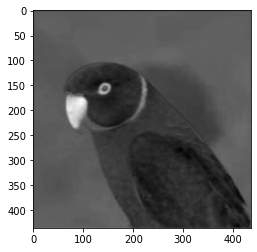

52


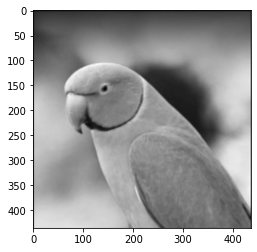

54


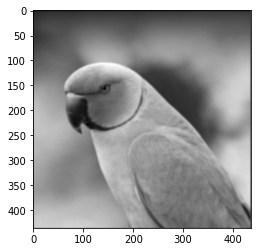

In [ ]:
for i in [7,22,41,47,52,54]: # посмотрим несколько примеров
  plt.imshow(vgg16.features[0](im.unsqueeze(0))[0][i].detach().numpy(), cmap='gray')
  print(i)
  plt.show()

## Настройка (Fine-tuning) предобученной модели


Загрузим CIFAR10

In [ ]:
batchSize = 100 # Зададим размер батча
numClasses = 10 # Зададим количество классов
numEpochs = 10 # Зададим количество эпох для обучения
learningRate = 0.01 # Зададим параметр learningRate для оптимайзера

trainDataset = dsets.CIFAR10(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True) # Загружаем обучающую выборку CIFAR10

testDataset = dsets.CIFAR10(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor()) # Загружаем тестовую выборку CIFAR10

trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, 
                                           batch_size=batchSize, 
                                           shuffle=True) # Создаем загрузчик для обучающей выборки

testLoader = torch.utils.data.DataLoader(dataset=testDataset, 
                                          batch_size=batchSize, 
                                          shuffle=False) # Создаем загрузчик для тестовой выборки

In [ ]:
iterator = iter(trainLoader)  # Создаем итератор для обучающей выборки
samples, labels = iterator.next() # Получим первую партию изображений и меток

In [ ]:
samples.shape # это наша конечная форма

torch.Size([100, 3, 32, 32])

In [ ]:
# Узнаем, с каким размером мы работаем, чтоб ввести правильные параметры слоя
print(vgg16.avgpool(vgg16.features(samples)).shape) # мы пропустили через features, передали на avgpool и посмотрели во что он слепил выборку

torch.Size([100, 512, 7, 7])


In [ ]:
for param in vgg16.parameters(): # поскольку мы будем тренировать под наш сет только последний слой
    param.requires_grad = False # не будем обновлять веса всей сети. Заморозим их

# Заменим последний слой для настройки под наш датасет
vgg16.classifier = nn.Linear(25088, 10) # 25088 = 7*7*512 - в качестве входных нейронов подаем результат вытягивания того, что на AveragePooling2D(avgpool)
                                        # на выходе 10 нейронов, т.к. 10 классов

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Проверка, если GPU включен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss() # Функция ошибки
optimizer = torch.optim.Adam(vgg16.classifier.parameters(), lr=learningRate)# Оптимизатор. Поскольку тренируем только слой классификатор, то его параметры и подаем на вход

# Обучим наш последний слой
for epoch in range(numEpochs):
    for i, (images, labels) in enumerate(trainLoader):          
        optimizer.zero_grad() # обнуляем градиенты
        outputs = vgg16(images.to(device)) # подаем наше изображение на вход
        loss = criterion(outputs, labels.to(device)) # считаем ошибку
        loss.backward() # берем производную
        optimizer.step() # делаем шаг оптимизатором
        
        if (i+1) % 250 == 0:
            print('Эпоха: [%d/%d], Шаг: [%d/%d], Потеря: %.4f' 
                  % (epoch+1, numEpochs, i+1, len(trainDataset)//batchSize, loss))

Эпоха: [1/10], Шаг: [250/500], Потеря: 14.9518
Эпоха: [1/10], Шаг: [500/500], Потеря: 19.3942
Эпоха: [2/10], Шаг: [250/500], Потеря: 17.6960
Эпоха: [2/10], Шаг: [500/500], Потеря: 17.8575
Эпоха: [3/10], Шаг: [250/500], Потеря: 16.5136
Эпоха: [3/10], Шаг: [500/500], Потеря: 18.2640
Эпоха: [4/10], Шаг: [250/500], Потеря: 23.1256
Эпоха: [4/10], Шаг: [500/500], Потеря: 21.1485
Эпоха: [5/10], Шаг: [250/500], Потеря: 21.4368
Эпоха: [5/10], Шаг: [500/500], Потеря: 16.1577
Эпоха: [6/10], Шаг: [250/500], Потеря: 17.0586
Эпоха: [6/10], Шаг: [500/500], Потеря: 14.2351
Эпоха: [7/10], Шаг: [250/500], Потеря: 16.5049
Эпоха: [7/10], Шаг: [500/500], Потеря: 15.7680
Эпоха: [8/10], Шаг: [250/500], Потеря: 16.7842
Эпоха: [8/10], Шаг: [500/500], Потеря: 19.0885
Эпоха: [9/10], Шаг: [250/500], Потеря: 19.4073
Эпоха: [9/10], Шаг: [500/500], Потеря: 16.0359
Эпоха: [10/10], Шаг: [250/500], Потеря: 15.3168
Эпоха: [10/10], Шаг: [500/500], Потеря: 20.8016


In [ ]:
#torch.save(vgg16, '/content/drive/My Drive/Предобученные сети/vgg16_pytorch.pkl')
vgg16 = torch.load('/content/drive/My Drive/Предобученные сети/vgg16_pytorch.pkl')

In [ ]:
curTime = time.time()
vgg16.to(device).eval()  # включаем режим проверки
correct = 0
total = 0

for images, labels in testLoader: # проходимся по всему тестовому загрузчику
    outputs = vgg16(images.to(device)) # классифицируем
    _, predicted = torch.max(outputs.data, 1) # вытаскиваем индексы лейблов
    total += labels.size(0) # здесь лежит количество всего
    correct += (predicted == labels.to(device)).sum() # считаем количество совпадений
    
print('Точность для 10000 картинок: %d %%' % (100 * correct // total))
print('time: ', round(time.time()-curTime,2),' с',sep='')

Точность для 10000 картинок: 61 %
time: 2.28 с


In [ ]:
predicted.shape # размер предикта 

torch.Size([100])

In [ ]:
images[0].shape # размер одной картинки

torch.Size([3, 32, 32])

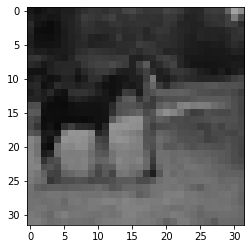

Предсказание: олень


In [ ]:
n = 78
im = images[n,1].numpy() # Превращаем шестую картинку в numpy
im = 255*np.reshape(im,(32,32)) # Приводим к формату RGB
x = Image.fromarray(im.astype(np.uint8)).convert('RGBA') #Данные массива должны быть универсальной кодировки и приводим к формату изображения

plt.imshow(x)
plt.show()

# Предсказание
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
print("Предсказание:", classes[predicted[n].item()])


# Перенос стиля

На базе алгоритма [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)

[Здесь](https://poloclub.github.io/ganlab/) можно ознакомиться с работой GAN наглядно.

![alt text](https://drive.google.com/uc?id=1FWNXrMjU_w-x6Up8FD_2PDX04Nk8Dwcs)![alt text](https://drive.google.com/uc?id=1MSv5M7183BUbmYg9M8UXYGjYVXgjXu1I)
![alt text](https://drive.google.com/uc?id=15S8uP05dByT54Szn58Dyf9wGZaWZwuGz)
![alt text](https://drive.google.com/uc?id=19ySsrFT_G0gy2QVRIUeu77E_PVWgSJwA)
![alt text](https://drive.google.com/uc?id=1Cv-LM9Nr8BNAUJkPDiaMGZu7I_Veehzb)
![alt text](https://drive.google.com/uc?id=1JddtR2VW_tZ5IGVyk9nXkGmsAlEwG0gm)
![alt text](https://drive.google.com/uc?id=1UoJ__R9iDp7Li0ozNFeraEjKReBjujxo)

In [ ]:
config = SimpleNamespace() # Создаем базовый класс пространства имен
config.content = '/content/drive/My Drive/Базы/Parakeet.jpg' # наша основная картинка
config.style = '/content/drive/My Drive/Базы/Style.jpg' # наша стилизованная картинка
config.maxSize = 400 # максимально допустимый размер изображения
config.totalStep = 600 # общее количество шагов за эпоху
config.step = 10 # шаг
config.sampleStep = 100 # шаг для сохранения образца
config.styleWeight = 100 #вес на стиль
config.lr = .003 

In [ ]:
# Проверка, если GPU включен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
class PretrainedNet(nn.Module):
    def __init__(self):
        # Инициализируем нашу модель
        super(PretrainedNet, self).__init__()
        self.select = [0, 5, 7, 10, 15] # те слои, через которые мы будем пропускать свое изображение
        self.pretrainedNet = models.vgg19(pretrained=True).to(device) # подгружаем предобученную сетку
        
    def forward(self, x):
        features = [] # Извлекаем по индексам, которые мы прописали выше, feature map из сетки
        output = x
        for layerIndex in range(len(self.pretrainedNet.features)):
          output = self.pretrainedNet.features[layerIndex](output)
          if layerIndex in self.select:
            features.append(output)
        return features

In [ ]:
def load_image(image_path, transform=None, maxSize=None, shape=None):
    # Загружаем изображение
    image = Image.open(image_path)
    
    # Если указан максимальный размер, то меняем размер нашего изображения
    if maxSize:
        scale = maxSize / max(image.size) # задаем масштаб для преобразования размера
        size = np.array(image.size) * scale # масштабированный размер
        image = image.resize(size.astype(int), Image.ANTIALIAS) # преобразуем 
        
    # Если указана форма изображением, меняем форму
    if shape:
        image = image.resize(shape, Image.LANCZOS)

    # Если указаны методы трансформирования, то применяем его
    if transform:
        image = transform(image).unsqueeze(0) # трансформировали + вытянули до батча
    
    return image.to(device)

In [ ]:
# Методы трансформирования изображения
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

In [ ]:
# Загружаем оригинал и стиль для картинок, применив нужные методы
content = load_image(config.content, transform, maxSize=config.maxSize)
style = load_image(config.style, transform, shape=[content.size(2), content.size(3)])


In [ ]:
# Создаем место под тензор для конечной картинки, указываем, что дифференцируем 
target = content.clone().requires_grad_(True)

In [ ]:
target.shape

torch.Size([1, 3, 400, 400])

In [ ]:
model = PretrainedNet().eval() # для использования весов предобученной сетки переводим ее в режим eval
optimizer = torch.optim.Adam([target], lr=0.1) # наша цель - не менять веса сетки, а менять изображение-тензор, поэтому указываем его в качестве параметра
contentCriteria = nn.MSELoss()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
for step in range(config.totalStep):
    # Для каждого из изображений извлекаем feature map
    targetFeatures = model.forward(target)
    contentFeatures = model.forward(content) 
    styleFeatures = model.forward(style)
    
    styleLoss = 0
    contentLoss = 0

    for f1, f2, f3 in zip(targetFeatures, contentFeatures, styleFeatures):
        # Вычисляем потери для оригинала и конечной картинки
        contentLoss += contentCriteria(f1, f2)
        #print(contentLoss)

        # Меняем форму сверточных feature maps. Приводим к формату (количество каналов, ширина*высота)
        _, c, h, w = f1.size() # пропускаем batch
        f1 = f1.reshape(c, h*w).to(device) 
        f3 = f3.reshape(c, h*w).to(device)

        # Находим матрицу Грама для конечной и стиля
        f1 = torch.mm(f1, f1.t()) 
        f3 = torch.mm(f3, f3.t())

        # Потери для стиля и конечной картинки
        kf1 = 1 / (4 * (len(f1)*len(f3))**2)
        kf2 = 1 / 4 * (len(f1)*len(f3))**2
        kf3 = 1 / (c * w * h)
        styleLoss += contentCriteria(f1,f3) * kf2
    # Прописываем конечную функцию потерь 
    loss = styleLoss + contentLoss
    #print(betta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (step+1) % config.step == 0:
        print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля: {}' 
               .format(step+1, config.totalStep, contentLoss.item(), styleLoss.item()))

    if (step+1) % config.sampleStep == 0: # сохраняем нашу картинку
        img = target.clone().squeeze() # создаем место под тензор
        img = img.clamp_(0, 1) # оставить значения, попадающие в диапазон между 0,1
        torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Шаг [10/600], Ошибка для оригинала: 108.6504, Ошибка для стиля: 1.572895363998679e+19
Шаг [20/600], Ошибка для оригинала: 142.9120, Ошибка для стиля: 6.421098977944404e+18
Шаг [30/600], Ошибка для оригинала: 143.3081, Ошибка для стиля: 3.7223691280449536e+18
Шаг [40/600], Ошибка для оригинала: 145.3743, Ошибка для стиля: 2.4376480651049697e+18
Шаг [50/600], Ошибка для оригинала: 144.8005, Ошибка для стиля: 1.742870378365059e+18
Шаг [60/600], Ошибка для оригинала: 145.2155, Ошибка для стиля: 1.345394588461826e+18
Шаг [70/600], Ошибка для оригинала: 145.3546, Ошибка для стиля: 1.095830462846206e+18
Шаг [80/600], Ошибка для оригинала: 145.6714, Ошибка для стиля: 9.266728666556006e+17
Шаг [90/600], Ошибка для оригинала: 145.9533, Ошибка для стиля: 8.039727978344612e+17
Шаг [100/600], Ошибка для оригинала: 146.1963, Ошибка для стиля: 7.110938895402926e+17
Шаг [110/600], Ошибка для оригинала: 146.4483, Ошибка для стиля: 6.37591812101374e+17
Шаг [120/600], Ошибка для оригинала: 146.6755, Ошиб

In [ ]:
styled_img = target.cpu().detach().numpy()[0].transpose(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


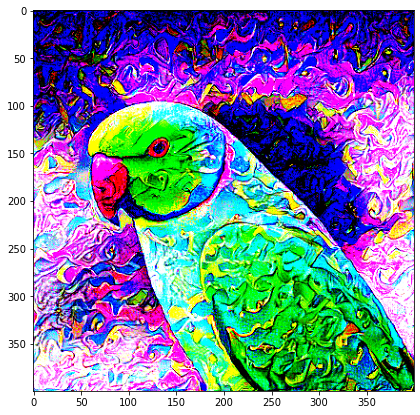

In [ ]:
plt.figure(figsize=(14,7))
plt.imshow(styled_img)
plt.show()